In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time, os, sys, pickle
import seaborn as sns
from tqdm import tqdm
import svgutils.compose as sc
import IPython.display as ip
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# import bptt_rnn as bp  # RNN, learning algorithm, loss function etc
import bptt_rnn_mtl as bpm
import plot_routines as pr  # plotting functions & directly related
import plot_routines_mtl as prm
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


cpu


In [2]:
torch.cuda.is_available()

False

In [32]:
# Data parameters dictionary
d_dict = { 'n_total': 1000,  # total number of data sequences
         'ratio_train': 0.8,
         'ratio_exp': 0.75,  # probabilities of switching between alpha nd beta
         'noise_scale': 0.15,
         't_delay': 2,
         't_stim': 2}

## Set training parameters:
t_dict = {}
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
t_dict['learning_rate'] = 0.002  # algorithm lr
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 80  # training epochs
t_dict['l1_param'] = 1e-4  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 


In [69]:
tmp0, tmp1 = bpm.generate_synt_data_general(n_total=d_dict['n_total'], t_delay=d_dict['t_delay'], t_stim=d_dict['t_stim'], 
                                        ratio_train=d_dict['ratio_train'], ratio_exp=d_dict['ratio_exp'],
                                        noise_scale=d_dict['noise_scale'], late_s2=False,
                                        nature_stim='periodic', task='dmc')
                    
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

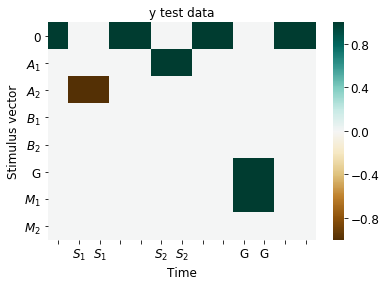

In [171]:
ax_true = plt.subplot(111)
k = np.where(labels_test == '30')[0]
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
prm.plot_example_trial(true_data.numpy(), ax=ax_true,
                     vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

In [157]:
y_test[:, 10, 5]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [303]:
rnn = bpm.RNN_MTL(task='dmc_only', nature_stim='periodic', n_nodes=t_dict['n_nodes'])  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

In [304]:
rnn = bpm.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                        x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test,
                        verbose=0, late_s2=False)

Epoch 79/80. Train loss: 0.026714: 100%|██████████| 80/80 [07:08<00:00,  5.35s/it]     


In [285]:
# print(rnn.test_loss_split.keys())
rnn.train_spec_task

True

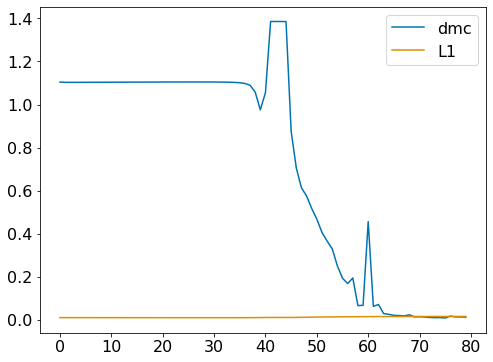

In [305]:
# for key in ['pred', 'dmc', 'S2']:
for key in ['pred', 'S2', 'G', '0', 'dmc', 'L1']:
    if key in rnn.test_loss_split.keys():
        arr = rnn.test_loss_split[key]
        plt.plot(arr, label=key)
plt.legend()

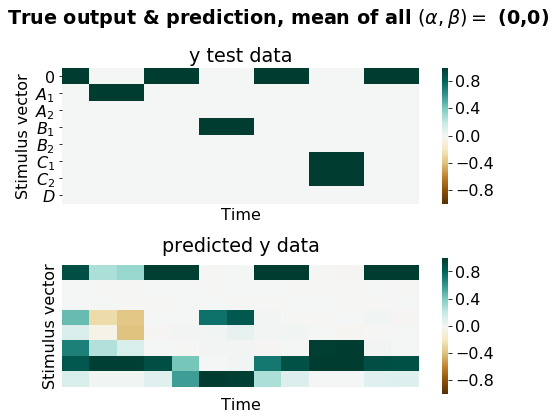

In [302]:
## Plot example test sample & prediction
k = np.where(labels_test == '00')[0]
# print(f'Trial type: {labels_test[k]}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
            xticklabels=[], vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
# if rnn.lin_output.out_features > rnn.n_stim:
pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
                      yticklabels=[],
               xticklabels=[], vmin=-1, c_map='BrBG')  # average if multiple samples
# else:
#     pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
#                xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

In [245]:
bpm.init_train_save_rnn(t_dict=t_dict, d_dict=d_dict, n_simulations=10, save_folder='models/norelu/pred_only/',
                        late_s2=False, nature_stim='onehot', type_task='dmc', train_task='pred_only')

bpm.init_train_save_rnn(t_dict=t_dict, d_dict=d_dict, n_simulations=10, save_folder='models/norelu/dmc_only/',
                        late_s2=False, nature_stim='onehot', type_task='dmc', train_task='spec_only')

bpm.init_train_save_rnn(t_dict=t_dict, d_dict=d_dict, n_simulations=10, save_folder='models/norelu/pred_dmc/',
                        late_s2=False, nature_stim='onehot', type_task='dmc', train_task='pred_spec')

Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]


-----------
simulation 0/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2122.data

-----------
simulation 1/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2125.data

-----------
simulation 2/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2129.data

-----------
simulation 3/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2132.data

-----------
simulation 4/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2135.data

-----------
simulation 5/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2139.data

-----------
simulation 6/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2142.data

-----------
simulation 7/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2145.data

-----------
simulation 8/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2149.data

-----------
simulation 9/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2152.data

-----------
simulation 0/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2155.data

-----------
simulation 1/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2159.data

-----------
simulation 2/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2202.data

-----------
simulation 3/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2205.data

-----------
simulation 4/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2208.data

-----------
simulation 5/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2212.data

-----------
simulation 6/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2215.data

-----------
simulation 7/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2218.data

-----------
simulation 8/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2222.data

-----------
simulation 9/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2225.data

-----------
simulation 0/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2228.data

-----------
simulation 1/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2232.data

-----------
simulation 2/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2235.data

-----------
simulation 3/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2239.data

-----------
simulation 4/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2242.data

-----------
simulation 5/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2245.data

-----------
simulation 6/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2249.data

-----------
simulation 7/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2252.data

-----------
simulation 8/10


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN-MTL model saved as rnn-mnm_2021-04-13-2255.data

-----------
simulation 9/10


Epoch 39/40. Train loss: 2.265527: 100%|██████████| 40/40 [03:23<00:00,  5.09s/it]     

RNN-MTL model saved as rnn-mnm_2021-04-13-2259.data


Instance rnn-mnm_2021-04-13-2259 of RNN_MTL Class

Trial type: ['2x']
dmc: 1.1250281810760498


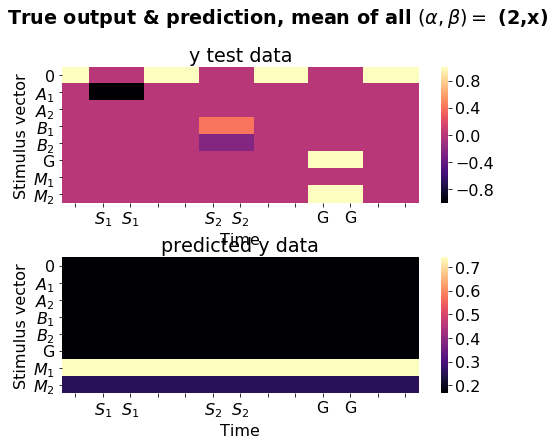

In [80]:
# i_rnn += 1
i_rnn =1
folder_rnn = '/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_5e-03/dmc_only/'
filename = os.listdir(folder_rnn)[i_rnn]
rnn = ru.load_rnn(os.path.join(folder_rnn, filename))

## Plot example test sample & prediction
k = np.where(labels_test == '2x')[0]
print(f'Trial type: {np.unique(labels_test[k])}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]

# part_spec_loss = bpm.specialisation_loss(y_est=pred, y_true=true_data, model=rnn)
# part_spec_loss = part_spec_loss.detach().numpy()
# print('part spec loss', part_spec_loss)

if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
prm.plot_example_trial(true_data.numpy(), ax=ax_true)
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
prm.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred)  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

for key in ['pred', 'dmc']:
    if key in rnn.test_loss_split.keys():
        print(f'{key}:', np.mean(rnn.test_loss_split[key][-5:]))

# full_pred = bpm.compute_full_pred(input_data=x_test, model=rnn)  # computed forward predictions
# spec_loss = bpm.specialisation_loss(y_est=full_pred, y_true=y_test, model=rnn)
# spec_loss = spec_loss.detach().numpy()
# print('spec loss', spec_loss)
# print('reg loss', bpm.regularisation_loss(model=rnn))

In [72]:
# rnn.info_dict
full_pred

tensor([[[0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         ...,
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580]],

        [[0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         ...,
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580]],

        [[0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.2580],
         [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.7420, 0.

cross_entropy
cross_entropy
cross_entropy


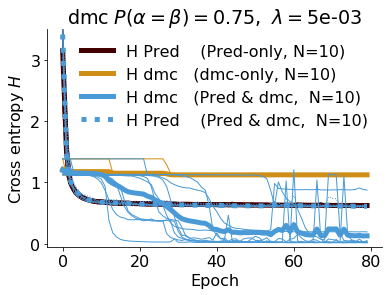

In [13]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 16
prm.plot_effect_eavesdropping_learning(task='dmc', ratio_exp_str='7525', nature_stim='onehot',
                                       sparsity_str='5e-03', ax=None, plot_legend=True,
                                       plot_std=False, plot_indiv=True)
# plt.savefig('figures/pred_mnm_errors.svg', bbox_inches='tight')

In [51]:
2 * torch.log(torch.Tensor([0.258]))

tensor([-2.7096])

Cutting of DF because of empty rows


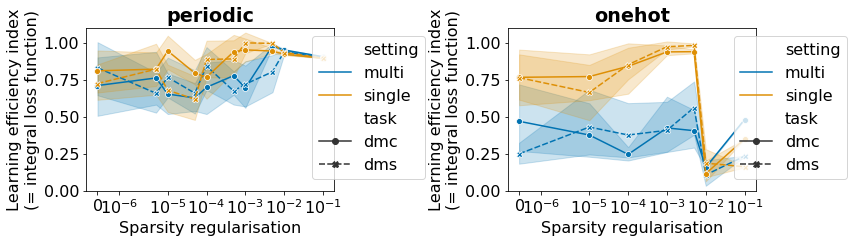

In [20]:
df = prm.plot_learning_efficiency(plot_difference=False)

Cutting of DF because of empty rows


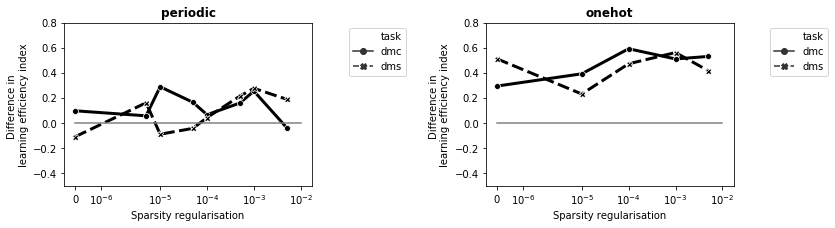

In [15]:
df = prm.plot_learning_efficiency(plot_difference=True)

/home/thijs/repos/rotation/plot_routines_mtl.py:95: RuntimeWarning: invalid value encountered in true_divide
  mat = mat / np.mean(mat[:, 0])#[:, np.newaxis]


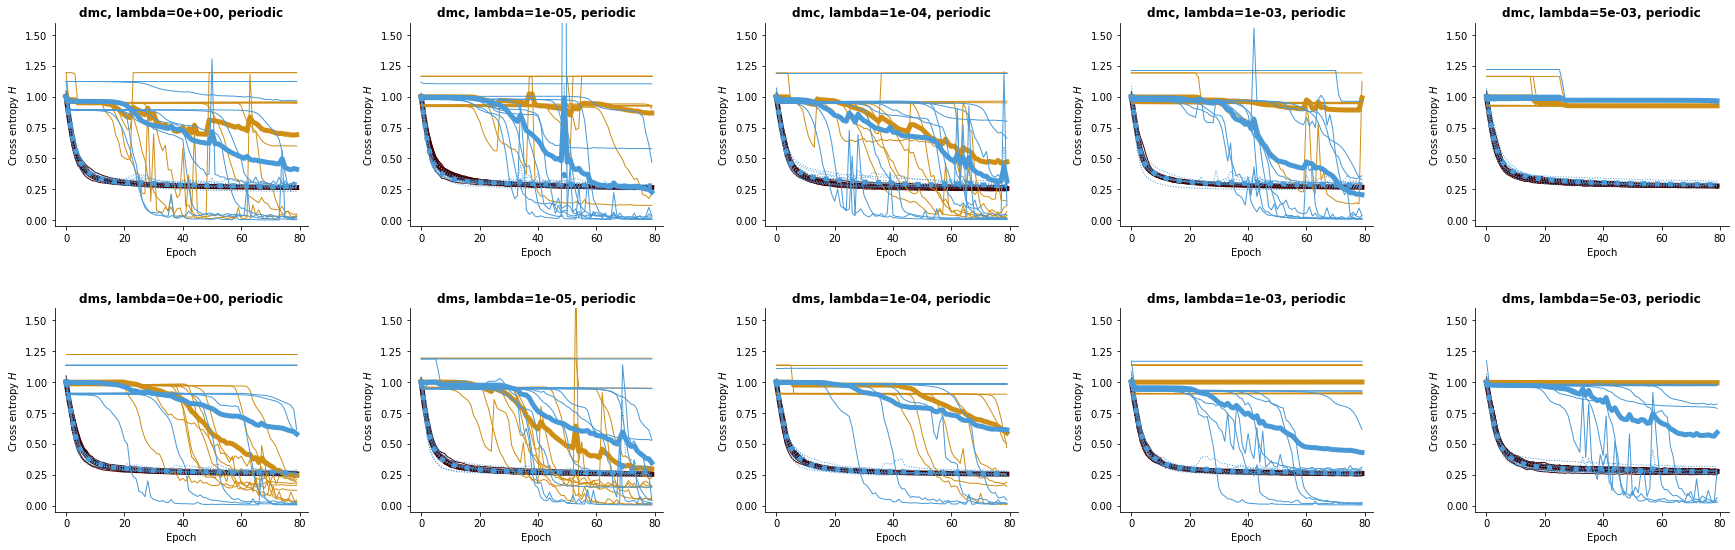

In [3]:
sparsity_str_arr = ['0e+00', '1e-05', '1e-04', '1e-03', '5e-03']
# sparsity_str_arr = ['0e+00', '5e-06', '1e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03']
fig, ax = plt.subplots(2, len(sparsity_str_arr), figsize=(len(sparsity_str_arr) * 6, 9), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
pr.set_fontsize(12)
for i_spars, spars in enumerate(sparsity_str_arr):
    for i_task, task in enumerate(['dmc', 'dms']):
        for i_nat, nat in enumerate(['periodic']):
            prm.plot_effect_eavesdropping_learning(task=task, ratio_exp_str='7525', 
                                                   sparsity_str=spars, nature_stim=nat,
                                                   ax=ax[i_task + 2 * i_nat][i_spars],
                                                   plot_std=False, plot_indiv=True,
                                                   plot_legend=(i_spars == 0 and i_task ==0 and i_nat == 0 and False))
            ax[i_task + 2 * i_nat][i_spars].set_title(f'{task}, lambda={spars}, {nat}', 
                                                     fontdict={'weight': 'bold'})
# plt.savefig('figures/learning_efficiency_dmc_dms_periodic_only.pdf', bbox_inches='tight')        

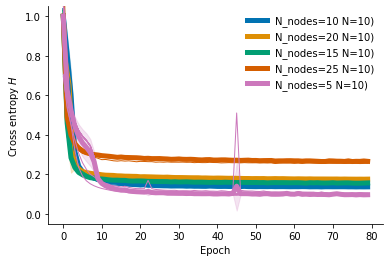

In [11]:
prm.plot_n_nodes_sweep(plot_indiv=True)

In [12]:
(x_train, y_train, x_test, y_test), (labels_train, labels_test) = bpm.generate_synt_data_general(n_total=1000, t_delay=2, t_stim=2,
                               ratio_train=0.8, ratio_exp=0.75,
                               noise_scale=0.05, late_s2=False,
                               nature_stim='onehot', task='dmc')

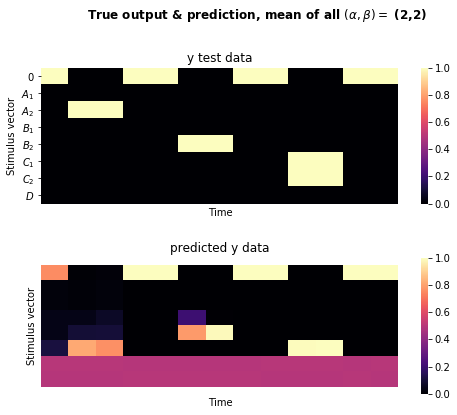

In [18]:
i_rnn =0
folder_comb = '/home/thijs/repos/rotation/models/sweep_n_nodes/7525/dmc_task/onehot/sparsity_5e-03/25_nodes/pred_only'
filename = os.listdir(folder_comb)[i_rnn]
rnn = ru.load_rnn(os.path.join(folder_comb, filename))

## Plot example test sample & prediction
k = np.where(labels_test == '22')[0]
# print(f'Trial type: {labels_test[k]}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
            xticklabels=[])
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
# if rnn.lin_output.out_features > rnn.n_stim:
pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
                      yticklabels=[],
               xticklabels=[])  # average if multiple samples
# else:
#     pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
#                xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

'44'

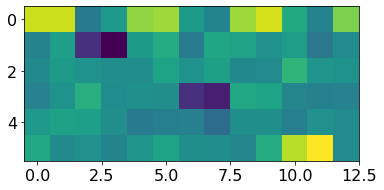

In [157]:
k += 1
plt.imshow(x_test[k, :, :].T)
labels_test[k]

In [161]:
# np.sum([x[0] == x[1] for x in labels_test]) / len(labels_test)
y_test[:, np.array([2, 3]), :][:, :, :6].mean()

tensor(0.0833)

(array([19., 19., 19.,  6., 19.,  6., 19., 19.,  0.,  6., 19., 19.,  6.,
         6.,  6.,  6.,  6.]),
 array([ 0.        ,  0.88235294,  1.76470588,  2.64705882,  3.52941176,
         4.41176471,  5.29411765,  6.17647059,  7.05882353,  7.94117647,
         8.82352941,  9.70588235, 10.58823529, 11.47058824, 12.35294118,
        13.23529412, 14.11764706, 15.        ]),
 <a list of 17 Patch objects>)

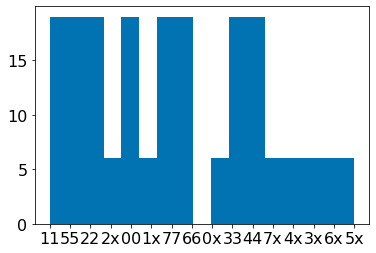

In [150]:
plt.hist(labels_test, bins=len(np.unique(labels_test)) + 1)